In [52]:
import torch
import warnings
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import transformers
from transformers import BertModel, BertTokenizer


from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from tqdm.notebook import tqdm
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 12, 8

warnings.filterwarnings("ignore")

In [2]:
# torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Загрузка данных

https://github.com/sismetanin/rureviews

Набор с примерами настроений из обзоров товаров категории «Женская одежда и аксессуары» в крупном российском интернет-магазине.

In [4]:
df = pd.read_csv('data/bert_training/women_clothing_accessories.zip', compression='zip', encoding='utf8', sep='\t')
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [6]:
class_names = df['sentiment'].unique()
class_names

array(['negative', 'neautral', 'positive'], dtype=object)

In [7]:
df.loc[df['sentiment'] == 'negative', 'sentiment'] = 0
df.loc[df['sentiment'] == 'neautral', 'sentiment'] = 1
df.loc[df['sentiment'] == 'positive', 'sentiment'] = 2
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,0
1,"Товар отдали другому человеку, я не получила п...",0
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",0
3,"товар не пришел, продавец продлил защиту без м...",0
4,"Кофточка голая синтетика, носить не возможно.",0


## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.

In [8]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [9]:
MAX_LEN = 128

class ReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt')

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)}

### Разбиение данных

In [10]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [11]:
df_train.shape, df_val.shape, df_test.shape

((81000, 2), (4500, 2), (4500, 2))

In [12]:
# df_train = df_train[:4100]
# df_val = df_val[:250]
# df_test = df_test[:250]

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = ReviewDataset(
        reviews=df.review.to_numpy(),
        targets=df.sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len)

    return DataLoader(ds, batch_size=batch_size)

In [14]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

## Модель

In [15]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.1)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(outputs["pooler_output"])
        return self.out(output)

In [17]:
model = SentimentClassifier(len(class_names))
model = model.to(device)
model

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affin

## Обучение модели

Для дообучения модели будем использовать оптимайзер AdamW. 

Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [18]:
EPOCHS = 4

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']

optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=2e-5)
loss_fn = nn.CrossEntropyLoss().to(device)

In [19]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0
  
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [20]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [21]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, len(df_train))

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'Val loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2532 [00:00<?, ?it/s]

Train loss 0.672595605371876 accuracy 0.6908641975308641


  0%|          | 0/141 [00:00<?, ?it/s]

Val loss 0.5924113204715945 accuracy 0.7297777777777779



  0%|          | 0/2532 [00:00<?, ?it/s]

Train loss 0.5658266781748377 accuracy 0.7479135802469136


  0%|          | 0/141 [00:00<?, ?it/s]

Val loss 0.5734895647417569 accuracy 0.7395555555555556



  0%|          | 0/2532 [00:00<?, ?it/s]

Train loss 0.524196937703785 accuracy 0.7681111111111111


  0%|          | 0/141 [00:00<?, ?it/s]

Val loss 0.5834138526561412 accuracy 0.7362222222222222



  0%|          | 0/2532 [00:00<?, ?it/s]

Train loss 0.48847093559672106 accuracy 0.7876419753086419


  0%|          | 0/141 [00:00<?, ?it/s]

Val loss 0.5968684160963018 accuracy 0.7353333333333334

Wall time: 1h 34min 54s


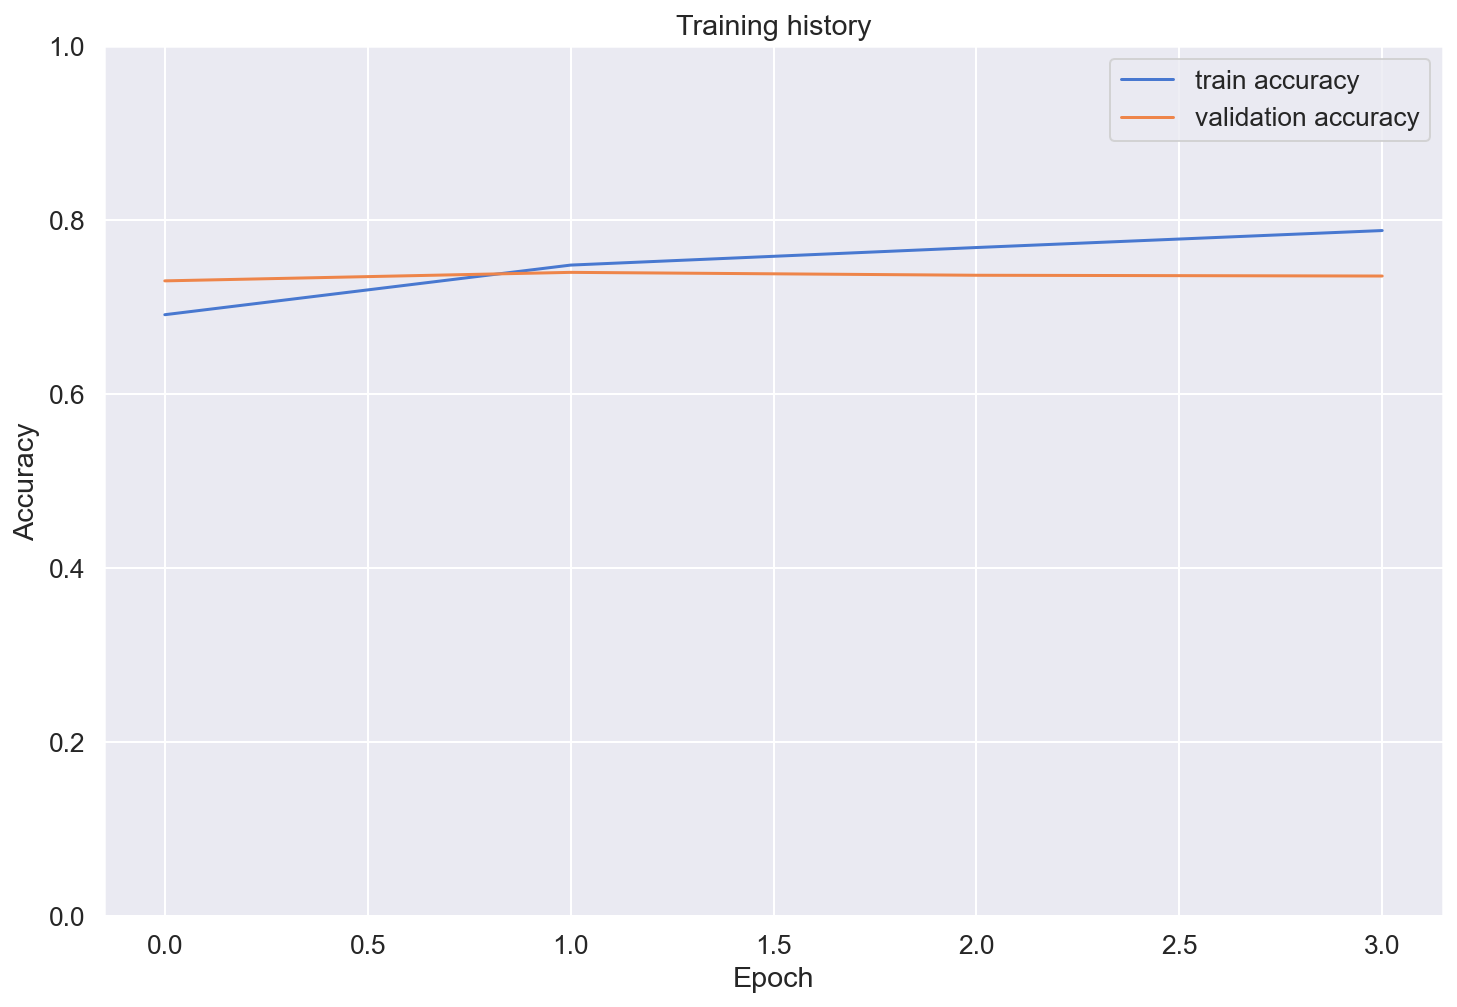

In [22]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## Оценка результатов работы модели

In [24]:
test_acc, _ = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

test_acc.item()

  0%|          | 0/141 [00:00<?, ?it/s]

0.7328888888888889

Результат меня не особо радует, думаю, выборка размечена неудачным образом, так как модель мощная. Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [25]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [26]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [27]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.74      0.68      0.71      1538
    neautral       0.59      0.72      0.65      1471
    positive       0.92      0.80      0.86      1491

    accuracy                           0.73      4500
   macro avg       0.75      0.73      0.74      4500
weighted avg       0.75      0.73      0.74      4500



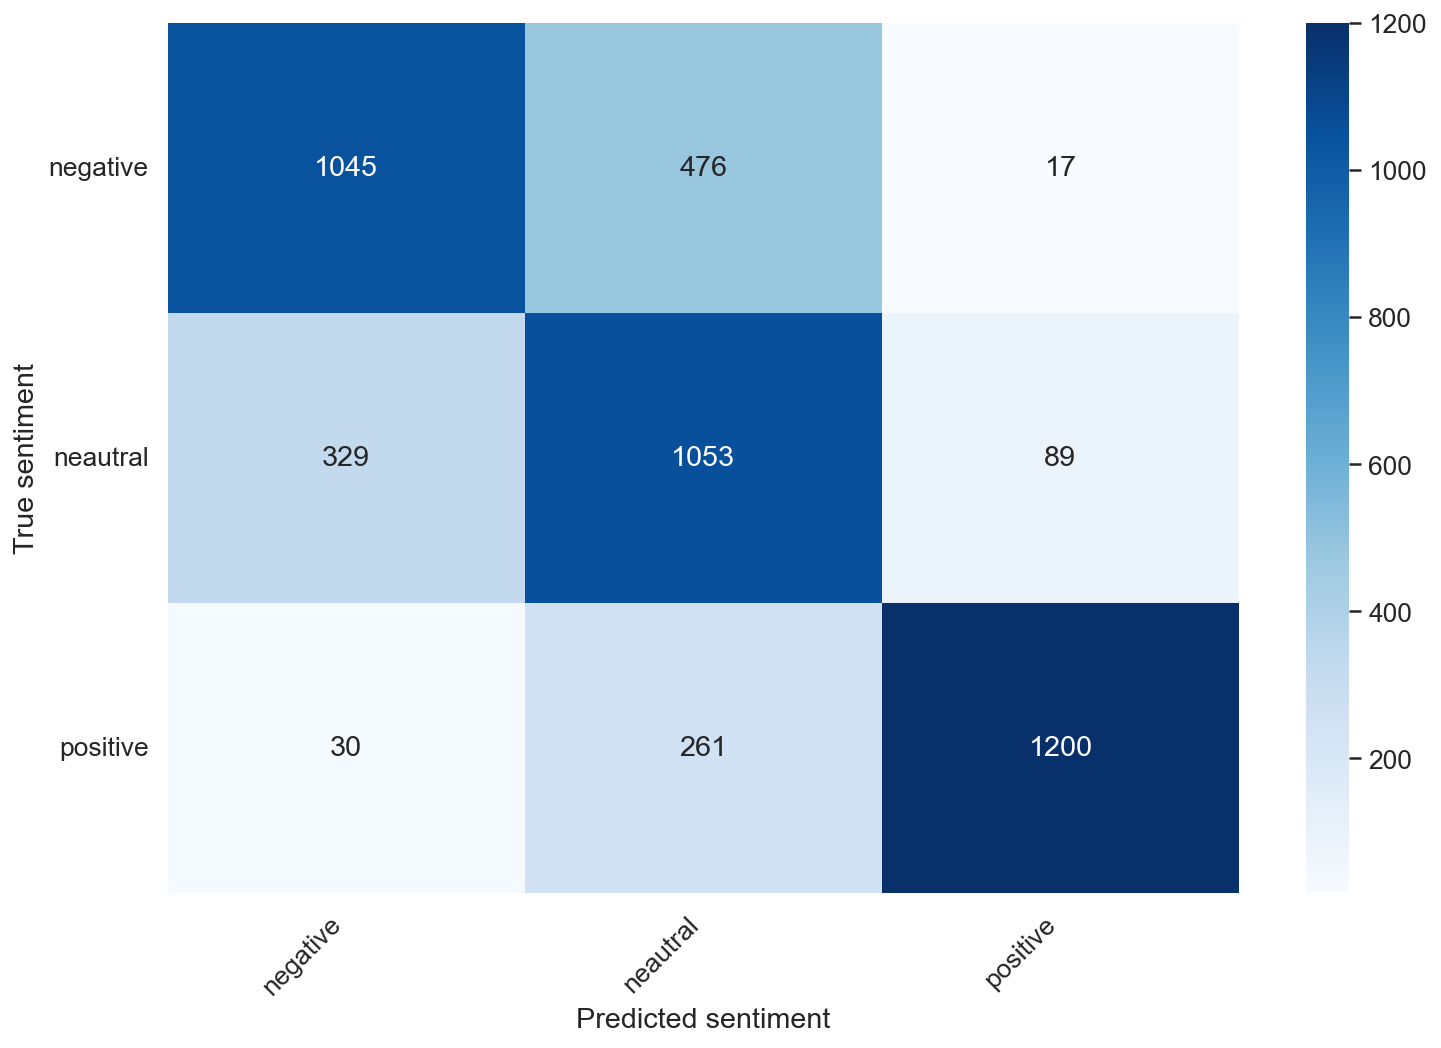

In [30]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [35]:
idx = 10

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [36]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')
pred_df

Думала кофта оказалась футболка и сидит она не так как на фото а в
обтяг

True sentiment: neautral


,class_names,values
0,negative,0.408548
1,neautral,0.581126
2,positive,0.010326


## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [55]:
review_text = "Духи как духи, зачем заказал? Хд, просто так)"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [56]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Теперь получим предсказания нашей модели.

In [57]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Духи как духи, зачем заказал? Хд, просто так)
Sentiment  : neautral


## Предсказание для набора данных

In [61]:
data = pd.read_csv('data/input/data.zip', sep=';', compression='zip', encoding='utf8')
data.head()

,text_review,review_id
0,Мне если честно аромат не очень.... Всегда ста...,75b8359b-2336-4759-880d-45c531c3470c
1,Туалетная вода от «Nina Ricci» - Nina L’Eau.Пр...,e7077664-72ae-49f5-a1b8-7b683fd07728
2,Очень приятный и свежий аромат. Ярко стартует ...,f99d2450-90dc-4914-9c02-6cf1d41de700
3,Cтал счастливым обладателем запечатанной миниа...,06fc790e-6dde-4835-ac00-5c1263884033
4,"Увидев на стенде Летуаль новинку от Shiseido, ...",4abc59a2-ebf0-44ed-b9fe-0ebe71f57807


In [66]:
def predict_review(review_text):
    encoded_review = tokenizer.encode_plus(
        review_text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt')
    
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    return class_names[prediction]

In [67]:
predict_review(data.text_review[0])

'neautral'

In [90]:
data['sentiment'] = np.nan

for index, line in enumerate(data.text_review):
    data['sentiment'][index] = predict_review(line)

In [91]:
data.head()

,text_review,review_id,sentiment
0,Мне если честно аромат не очень.... Всегда ста...,75b8359b-2336-4759-880d-45c531c3470c,neautral
1,Туалетная вода от «Nina Ricci» - Nina L’Eau.Пр...,e7077664-72ae-49f5-a1b8-7b683fd07728,negative
2,Очень приятный и свежий аромат. Ярко стартует ...,f99d2450-90dc-4914-9c02-6cf1d41de700,positive
3,Cтал счастливым обладателем запечатанной миниа...,06fc790e-6dde-4835-ac00-5c1263884033,neautral
4,"Увидев на стенде Летуаль новинку от Shiseido, ...",4abc59a2-ebf0-44ed-b9fe-0ebe71f57807,neautral


In [92]:
compression_opts = dict(method='zip', archive_name='out.csv')  
data.to_csv('data/result/predict_data.zip', index=False, compression=compression_opts) 

In [96]:
data['sentiment'].value_counts()

neautral    33811
positive     9368
negative     6821
Name: sentiment, dtype: int64

Сомневаюсь в таком перекосе в сторону нейтрального класса. Думаю, стоит дообучать модлеь на другом наборе данных.